## LGA Airline Passengers

In [6]:
import json 
import pandas as pd 
import numpy as np 
import math 
import itertools 
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure 
from load_dataset import TimeSeries 

In [7]:
# True labels
annotations = pd.read_json('TCPD-master/annotations.json')
annotations[['lga_passengers']]

,lga_passengers
6,"[169, 296, 384]"
7,[]
8,"[169, 296, 385]"
9,"[14, 84, 122, 164, 231, 298, 384]"
10,NaN
12,"[132, 169, 296, 382]"
13,NaN
14,NaN


In [8]:
# List true changepoints
annotator_df = pd.read_json('TCPD-master/annotations.json') 
lga_passengers_df = annotator_df[['lga_passengers']] 
list2d = np.array(lga_passengers_df).flatten() 
list2d = [l for l in list2d if (type(l)==list)] 
lga_passengers_annotation_lst = list(itertools.chain.from_iterable(list2d))
lga_passengers_annotation_lst

[169,
 296,
 384,
 169,
 296,
 385,
 14,
 84,
 122,
 164,
 231,
 298,
 384,
 132,
 169,
 296,
 382]

t                         int64
Number of Passengers    float64
date                     object
dtype: object


<Figure size 960x480 with 0 Axes>

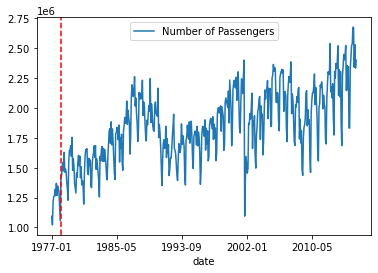

In [11]:
# Plot true changepoints
from load_dataset import TimeSeries
ts = TimeSeries.from_json('TCPD-master/datasets/lga_passengers/lga_passengers.json')
lga_passengers_df = ts.df
lga_passengers_df['date'] =ts.datestr
print(lga_passengers_df.dtypes)
figure(figsize=(12, 6), dpi=80)
lga_passengers_df.plot('date', 'Number of Passengers')
lga_passengers_df['is_CPD'] = np.where(lga_passengers_df.t.isin(lga_passengers_annotation_lst), 1,0)
plt.axvline(lga_passengers_df.loc[lga_passengers_df['is_CPD']==1][['t']].values[0], color='red', linestyle='--')

In [16]:
lga_passengers_df[169:383]

,t,Number of Passengers,date,is_CPD,time
169,169,1349872.0,1991-02,1,1991-02-01
170,170,1551938.0,1991-03,0,1991-03-01
171,171,1698294.0,1991-04,0,1991-04-01
172,172,1733802.0,1991-05,0,1991-05-01
173,173,1660448.0,1991-06,0,1991-06-01
...,...,...,...,...,...
378,378,2157538.0,2008-07,0,2008-07-01
379,379,2171070.0,2008-08,0,2008-08-01
380,380,1740889.0,2008-09,0,2008-09-01
381,381,1906311.0,2008-10,0,2008-10-01


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



total changepoints-->  1


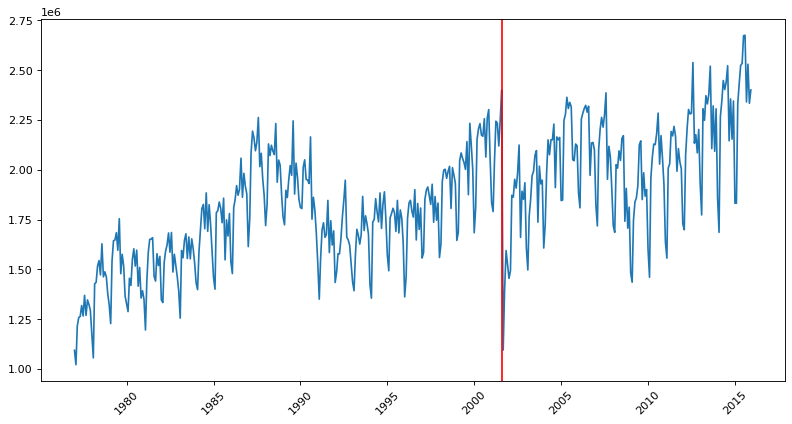

In [14]:
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters
from kats.consts import TimeSeriesData

df = lga_passengers_df
df['time']= pd.to_datetime(df['date'])


tsd = TimeSeriesData(df.loc[:,['time','Number of Passengers']])

# Initialize the detector
detector = BOCPDetector(tsd)


changepoints = detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL, # this is the default choice
    #model_parameters=[known_prec_multiplier=1.0]
    lag=10,
    changepoint_prior=.5,#prior belief
    threshold=.9
)

print('total changepoints--> ', len(changepoints))

figure(figsize=(12, 6), dpi=80)
# Plot the data
plt.xticks(rotation=45)
detector.plot(changepoints)
plt.show()

In [15]:
changepoints

[(TimeSeriesChangePoint(start_time: 2001-08-01T00:00:00.000000000, end_time: 2001-08-01T00:00:00.000000000, confidence: 0.9787286716001473),
  <kats.detectors.bocpd.BOCPDMetadata at 0x7fcbb70320d0>)]

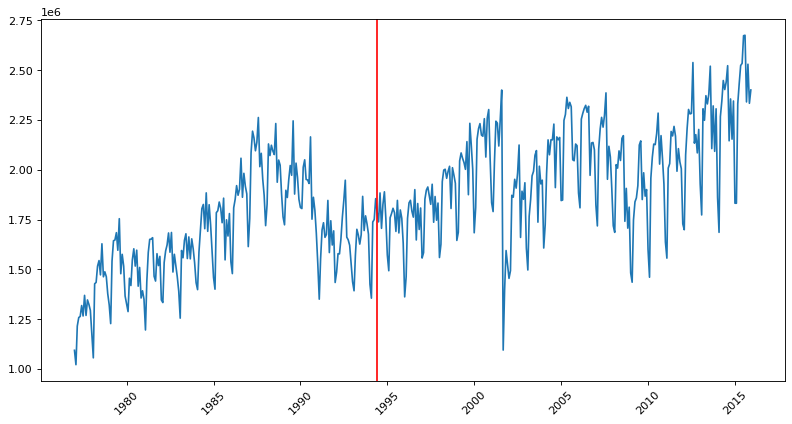

In [20]:
#Robust Stat Detector
from kats.detectors.robust_stat_detection import RobustStatDetector

detector = RobustStatDetector(tsd)
change_points = detector.detector(comparison_window=50, smoothing_window_size=50, p_value_cutoff=0.01)
figure(figsize=(12, 6), dpi=80)
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

In [21]:
change_points

[(TimeSeriesChangePoint(start_time: 1994-06-01T00:00:00.000000000, end_time: 1994-06-01T00:00:00.000000000, confidence: 0.9901837271759634),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7fcbb79a8610>)]

total changepoints-->  1


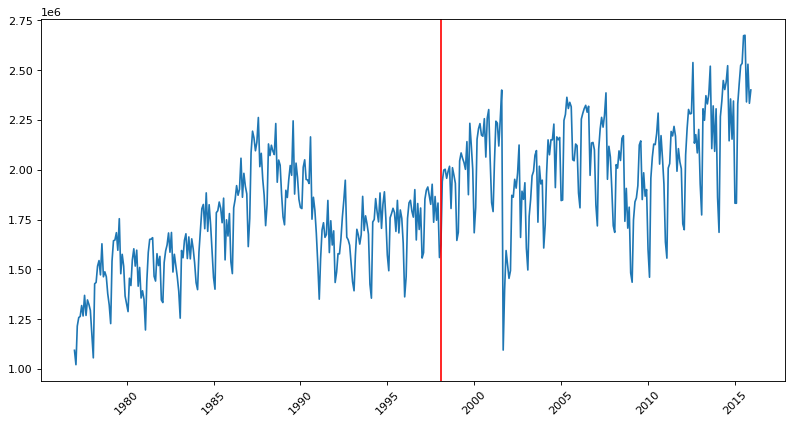

In [22]:
# CUSUM
from kats.detectors.cusum_detection import CUSUMDetector


# Initialize the detector
detector = CUSUMDetector(tsd)

change_points = detector.detector(threshold=0.05)

print('total changepoints--> ', len(change_points))

figure(figsize=(12, 6), dpi=80)
# Plot the data
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

In [23]:
change_points

[(TimeSeriesChangePoint(start_time: 1998-02-01 00:00:00, end_time: 1998-02-01 00:00:00, confidence: 1.0),
  <kats.detectors.cusum_detection.CUSUMMetadata at 0x7fcbb799d040>)]

#### Annotation -> 1991
#### BOCPD -> 2001
#### RobustStatDetector -> 1994
#### CUSUM -> 1998